# Abstract

The standard Perceptron algorithm iteratively updates a weight vector for binary classification, with each iteration running in O(p) time, where p is the number of features. While the number of data points (n) does not affect individual updates. Experiments show that the Perceptron always converges on linearly separable data, though iteration count varies. Notably, higher-dimensional data converges faster, suggesting that additional features aid optimization. The algorithm will never converge on linearly separable data and demonstrates high volatility in the loss after each update. When Perceptron is implemented with minibatch, this both allows for smoother convergence as well as the potential to converge on linearly inseparable data. 

# Methods Overview

Perceptron source code used in this project: https://raw.githubusercontent.com/Nibsquatch/Nibsquatch.github.io/refs/heads/main/perceptron.py

Perceptron.grad() was implemented by taking as input a randomely selected batch of entries in the feature matrix and the associated target vector. The target vector comes in the form {0,1} and is converted to {-1, 1} respectively. The score for the entry is computed, and if the score is negative then a perceptron update is passed, otherwise an update containing only a zero shift is passed. When there are more than one entries in the batch, the updates is passed as average of the updates for each misclassified point. A learning rate is also passed, with 1 representing a standard Perceptron update when the batch size also equals 1.  

# Loading Perceptron

In [2]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

# Testing That Our Perceptron Algorithim Works

Lets run a training loop to check that our Peceptron algorithim is running as expected and will eventually achieve a loss equal to 0 on linearly separable data. First we will need to generate linearly separable data. 

In [3]:
from matplotlib import pyplot as plt
import torch
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

# first we need to generate data

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

# assign the example data to variables
X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

Now that we have generated linearly separable data, lets visualize before we begin implementing linear decision boundaries.

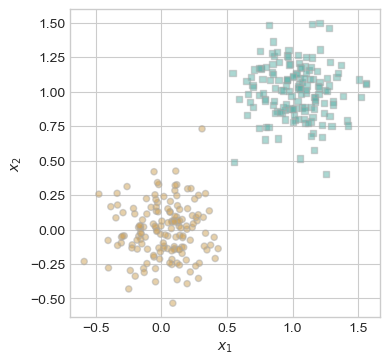

In [4]:
# Visualize our training data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

Time to initiate our training model to test whether or not our Perceptron Algorithim can achieve a loss of 0. 

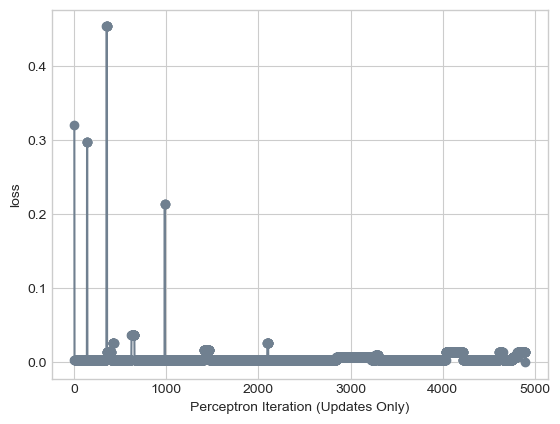

In [5]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point batch
    k = 1 # k = 1 one to serve as a standard perceptron update
    ix = torch.randperm(X.size(0))[:k]
    x_ix = X[ix,:]
    y_ix = y[ix]
    
    # perform a perceptron update using the random data point (with alpha = 1 to perform standard perceptron update)
    opt.step(x_ix, y_ix, 1)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Although it took a large number of iterations, our perceptron algorithim was eventually able to reach a loss of 0 and is able to identify the proper weight vector to linearly separate the data points. Lets look at our data with the final weight vector plotted.

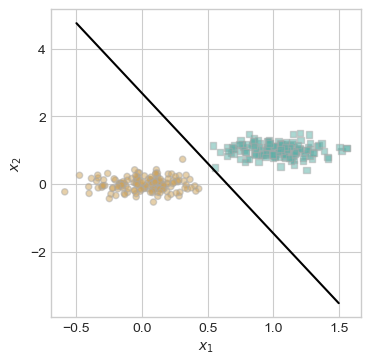

In [6]:
# define a function to plot a line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# plot the existing data and add a line to the graph
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

plot_perceptron_data(X, y, ax) # plot data
draw_line(p.w, -.5, 1.5, ax, color = "black") # draw weight vector

From the visualization, we can tell that the minimization of loss 0 has correctly identified a linear line which perfectly separates the data into their correct classes. Now, let's explore the algorithim performs on data which is mathematically impossible to seprate linearly. A max iterations of 1000 will be applied to the training loop, as the algorithim will run forever without a cap. 

In [7]:
# Generate Linearly Inseparable Data
def perceptron_data_insep(n_points = 270, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # add 30 points that are the opposite class in a similar location as a previous point, thus making linearly inseparable data
    for _ in range(30):  
        rand_i = torch.randint(0, n_points, (1,))  # Pick a random point index
        x_new = X[rand_i] + torch.normal(0.0, noise, size=(1, p_dims + 1))  # Slightly modify the chosen point
        
        # flip class
        y_new = torch.tensor([1 - y[rand_i].item()])  # Convert to tensor

        X = torch.cat((X, x_new), dim=0)  # Add new point
        y = torch.cat((y, y_new), dim=0)  # Add new label

    return X, y


Now that we have generated linearly inseparable data, lets visualize before we attempt to implement a linear decision boundaries.

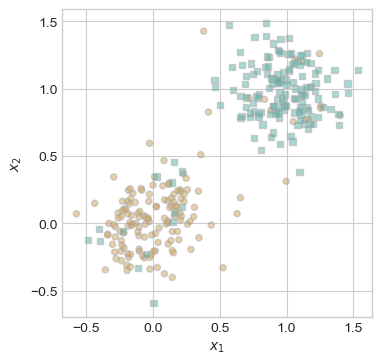

In [8]:
# Visualize our training data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data_insep()
plot_perceptron_data(X, y, ax)

Time to initiate a training model on linearly inseparable data, with a max iterations of 1000.

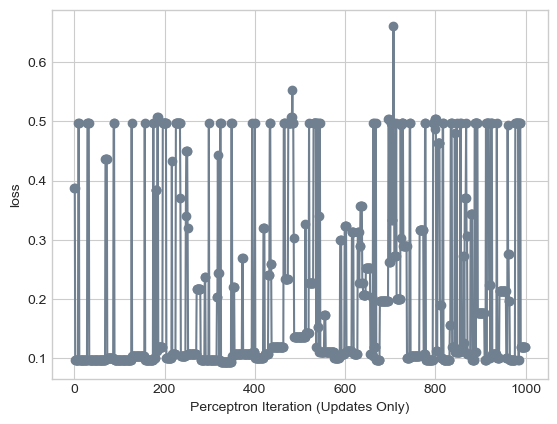

In [9]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

iterations = 0

while loss > 0 and iterations < 1000: # terminates after 5,000 iterations since the data is linearly inseparable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point batch
    k = 1 # k = 1 one to serve as a standard perceptron update
    ix = torch.randperm(X.size(0))[:k]
    x_ix = X[ix,:]
    y_ix = y[ix]
    
    # perform a perceptron update using the random data point (with alpha = 1 to perform standard perceptron update)
    opt.step(x_ix, y_ix, 1)

    # iterate
    iterations += 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Compared to the linearly separable data, the algorithim has significant trouble minimizing the loss. Instead of a generally smooth curve, the loss function jumps from low to high as there is never a solution to the problem the algorithim is trying to solve. Lets look at our data with the final weight vector plotted, despite the weight vector being imperfect. 

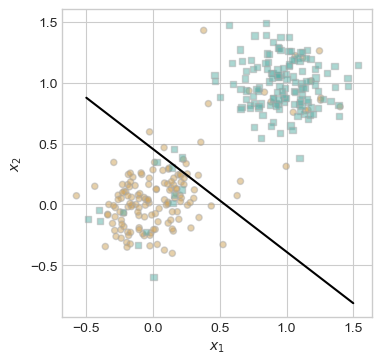

In [10]:
# plot the existing data and add a line to the graph
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

plot_perceptron_data(X, y, ax) # plot the data
draw_line(p.w, -.5, 1.5, ax, color = "black") # plot the final weight vector

As expected, our model is not able to perfectly differentiate between classes, as there is no linear classifier that can accomplish the task. Now lets explore how the loss function evolves on data of more than two dimenstions.

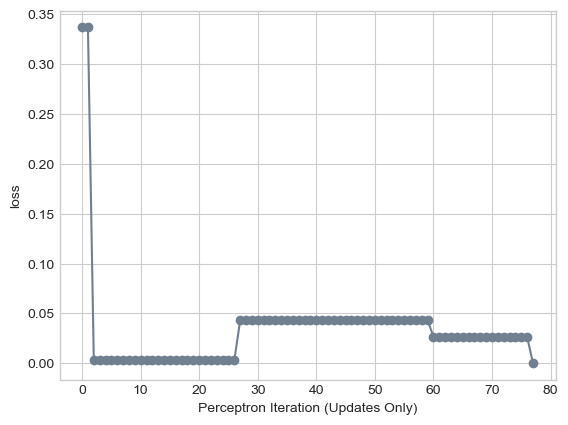

In [14]:
# Generate 5 dimensional data
def perceptron_data5(n_points = 300, noise = 0.2, p_dims = 5):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    return X, y

X, y = perceptron_data5()

# perform the training loop
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point batch
    k = 1 # k = 1 one to serve as a standard perceptron update
    ix = torch.randperm(X.size(0))[:k]
    x_ix = X[ix,:]
    y_ix = y[ix]
    
    # perform a perceptron update using the random data point (with alpha = 1 to perform standard perceptron update)
    opt.step(x_ix, y_ix, 1)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

The Perceptron Algorithim is able to work extremely quickly to reduce the loss to 0, even on data with dimensionality greater than 2; in fact,  the Perceptron algorithm seems to run even faster for data of higher dimensionality. Lets explore if 10 dimensional data will be optimized even faster. 

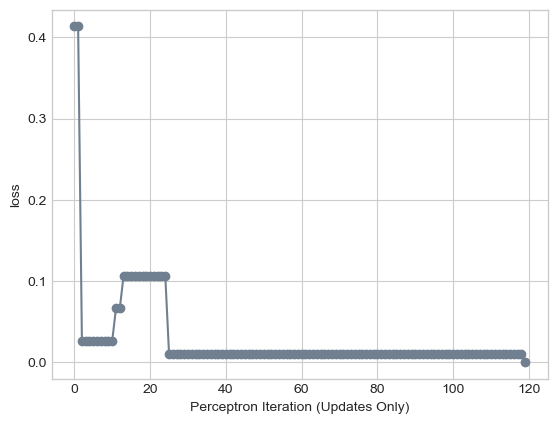

In [18]:
# Generate 10 dimensional data
def perceptron_data10(n_points = 300, noise = 0.2, p_dims = 10):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    return X, y

X, y = perceptron_data10()

# perform the training loop
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point batch
    k = 1 # k = 1 one to serve as a standard perceptron update
    ix = torch.randperm(X.size(0))[:k]
    x_ix = X[ix,:]
    y_ix = y[ix]
    
    # perform a perceptron update using the random data point (with alpha = 1 to perform standard perceptron update)
    opt.step(x_ix, y_ix, 1)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Although the Perceptron algorithim optimized the weight vector for the 10 dimensional data much faster than it did for 2 dimensional data, the rate of optimization does not seem to have a purely linear relationship. In general, multidimensional data does seem to be able to be optimized faster than simple 2 dimensional data.

# MiniBatch Experiments

Lets now explore how altering the size of the data batch as well as the canging the learing rate affects how quickly the model converges to a loss of 0 on simple, linearly separable data with 2 dimensions. Lets start by comparing k = 1, 10, and n (where n is the size of the dataset) with a constant learing rate of 1.0.

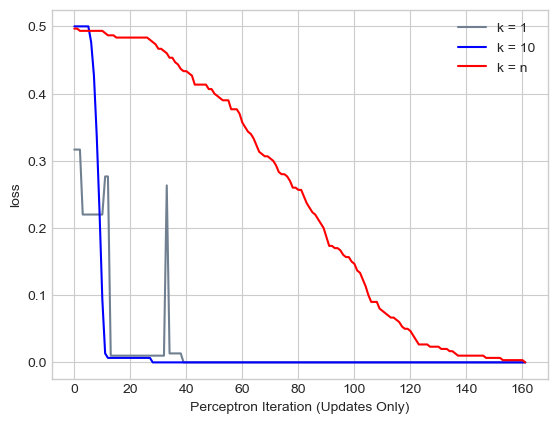

In [21]:
# Generate Fresh Linearly Separable Data
X, y = perceptron_data()

# instantiate the models and optimizers
p1 = Perceptron()
p10 = Perceptron() 
pn = Perceptron() 

opt1 = PerceptronOptimizer(p1)
opt10 = PerceptronOptimizer(p10)
optn = PerceptronOptimizer(pn)

# for keeping track of loss values
loss1_vec = []
loss10_vec = []
lossn_vec = []

loss = 1.0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss1_vec.append(p1.loss(X,y))
    loss10_vec.append(p10.loss(X,y))
    lossn_vec.append(pn.loss(X,y))

    # calculates the average loss of the 3 models
    loss = (p1.loss(X,y) + p10.loss(X,y) + pn.loss(X,y)) / 3
    
    # pick a single random data point batch
    ix = torch.randperm(X.size(0))[:1]
    x_1 = X[ix,:]
    y_1 = y[ix]

    # pick a 10 random data point batch
    ix = torch.randperm(X.size(0))[:10]
    x_10 = X[ix,:]
    y_10 = y[ix]

    # take the whole dataset
    
    # perform a perceptron update using the random data point (with alpha = 1) for each model and batch size
    opt1.step(x_1, y_1, 1)
    opt10.step(x_10, y_10, 1)
    optn.step(X, y, 1)

plt.plot(loss1_vec, color = "slategrey", label = "k = 1")
plt.plot(loss10_vec, color = "blue", label = "k = 10")
plt.plot(lossn_vec, color = "red", label = "k = n")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.legend()


With values of k spanning 1, 10, n each form of Perceptron was able to converge to a loss 0 in a similar number of iterations. However, it appears that as k grows larger the rate of convergence beceoms more stable. This is demonstrated as the standard, k = 1, Perceptron algorithim has large changes in loss followed by regions of no improvment. As k grows larger cruves appear to smooth out, and descend slower but more consistently. Now, lets see how a Perceptron algorithm with k = n performs on linearly inseparable data with a sufficiently small alpha. 

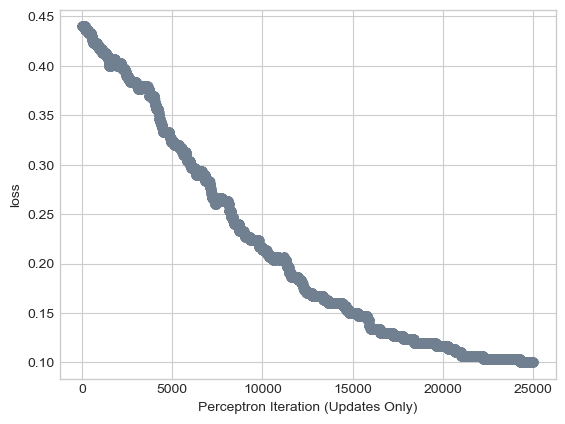

In [47]:
# Generate fresh linearly inseparable data
X, y = perceptron_data_insep()

# instantiate the model and optimizer
p = Perceptron()
opt = PerceptronOptimizer(p)

# for keeping track of loss
loss_vec = []

loss = 1.0
iterations = 0

while loss > 0 and iterations < 25000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # perform a perceptron update using k = n and a small alpha
    opt.step(X, y, .005)

    iterations += 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

To spare wasting time and computational powers, the number of iterations was limited to 25,000. However, the overall trend seems to be a gradual convergence to 0 loss at a decreasing rate. It can be assumed that if unlimited iteratins could be allowed then the model would eventually converge to a loss of 0 for minibatch perceptron with a small alpha (such as .005) and k = n. 

# Discussion

Reflecting on the time complexity of the standard Perceptron algorithm, the algorithim selects a random point which takes O(1) time; although the number of entries (n) may increase this does not affect the runtime of selecting one at random. However, for each Perceptron update the score for this entry must be calculated which is dependent on the number of features (p), as each score is calculated as a dot product. Thus, each iteration of the Perceptron algorithim takes O(p) time. 

Findings: When given linearly separable data the standard Perceptron algorithm will always find a weight vector that achieves a loss of 0, even if it takes in some cases thousands of iterations; the time it takes for the Perceptron algorithm to optimize the weight vector also seems to have some relationshop to the number of dimensions in the data, with multidimensional data being optimized in much fewer iterations than simple 2 dimensional data. The algorithm will also never converge on non linearly separable data, and the loss fucntion across each Perceptron update demonsrates high volatility, as each update is attempting to reach a solution which does not exist. With regards to minibatch Perceptron, the larger value of k the more stable the increase in accuracy but often the longer it takes to converge. The learning rate alpha can also effect this rate. 